In [1]:
import scanpy as sc

In [2]:
# 设置参数
sc.settings.verbosity = 4
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=300,
    facecolor="white",
    frameon=False,  # remove frame
)

In [3]:
## 准备R环境
import anndata2ri
import logging 

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.CRITICAL) # 
ro.pandas2ri.activate() # type: ignore
anndata2ri.activate()

%load_ext rpy2.ipython 

/tmp/ipykernel_3665736/2952535687.py:10: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
## 读取adata
adata = sc.read("anndata_celltypist_anno.h5ad")
# 清理没使用到的分类
adata.obs["celltypist_cell_label_coarse"] = adata.obs["celltypist_cell_label_coarse"].cat.remove_unused_categories()
# 需要过滤注释不为空的数据
adata = adata[adata.obs["celltypist_cell_label_coarse"].notnull()].copy()

/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
## 准备数据传给R
cells = adata.obs_names
genes = adata.var_names
meta_data = adata.obs
data_input = adata.X.T

In [6]:
%%R -i cells -i genes -i meta_data -i data_input
library(CellChat)
library(ggalluvial)
library(patchwork)
library(NMF)

## 需要转换成一种矩阵格式
data_input <- as.matrix(data_input)
rownames(data_input) <- genes
colnames(data_input) <- cells

cellchat <- createCellChat(object = data_input, meta = meta_data, group.by = "celltypist_cell_label_coarse")



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    [1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  B cells DC Endothelial cells Epithelial cells Fibroblasts ILC Macrophages Mast cells Monocytes Plasma cells T cells pDC 


Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: ggplot2
Loading required package: registry
Loading required package: rngtools
Loading required package: cluster
NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2
  To enable shared memory capabilities, try: install.extras('
NMF
')

Attaching package: ‘NMF’

The following objects are masked from ‘package:igraph’:

    algorithm, compare



In [7]:
%%R 
# 设置cellType为默认的细胞分类方式
# cellchat <- addMeta(cellchat, meta = meta)
# cellchat <- setIdent(cellchat, ident.use = "celltypist_cell_label_coarse")

# 导入人类、小鼠配体受体数据库
# TODO:注意数据库的选择
# CellChatDB <- CellChatDB.mouse
CellChatDB <- CellChatDB.human

# 使用整个配体库来识别相互作用
CellChatDB.use <- CellChatDB
cellchat@DB <- CellChatDB.use

# 提取细胞通讯相关基因
cellchat <- subsetData(cellchat)
future::plan("default")


In [8]:
%%R 

# 鉴定高表达的配体和受体
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

# 将配体受体相关基因表达值投射到互作网络上并进行校正，时间较久
# TODO：注意数据库的选择
# cellchat <- projectData(cellchat, PPI.mouse) 
cellchat <- projectData(cellchat, PPI.human)



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~05s           |++                                                | 3 % ~04s           |+++                                               | 4 % ~05s           |+++                                               | 6 % ~05s           |++++                                              | 7 % ~04s           |+++++                                             | 8 % ~04s           |+++++                                             | 10% ~04s           |++++++                                            | 11% ~04s           |+++++++                                           | 13% ~04s           |++++++++                                          | 14% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 17% ~04s           |++++++++++                                        | 18% ~03s 

In [9]:
%%R
# 推断细胞通讯网络，为每个通讯网络计算一个概率值和对应的p值
cellchat <- computeCommunProb(cellchat, raw.use = TRUE) # raw.use表示使用未校正的数据
cellchat <- filterCommunication(cellchat, min.cells = 10)
cellchat <- computeCommunProbPathway(cellchat)

# 统计细胞通讯数量和强度（概率）
cellchat <- aggregateNet(cellchat)
groupSize <- as.numeric(table(cellchat@idents))


triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-11-07 10:17:48.912933]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-11-07 10:21:02.230916]"


  |======================================================================| 100%


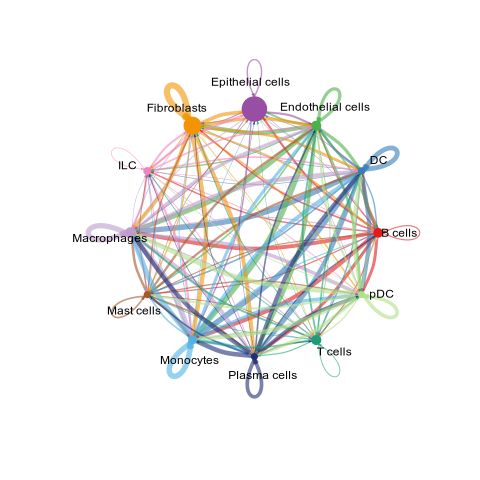

In [10]:
%%R
# 生成细胞通讯网络的可视化图（圆形图）
pdf("./figures/09-cellchat_circle_weight.pdf", height = 13/2.6, width = 13/2.6)
netVisual_circle(cellchat@net$count,
                 vertex.weight = groupSize,
                 weight.scale = T,
                 label.edge= F,
                 title.name = "Number of interactions")
dev.off()
netVisual_circle(cellchat@net$count,
                 vertex.weight = groupSize,
                 weight.scale = T,
                 label.edge= F,
                 title.name = "Number of interactions")

Do heatmap based on a single object 



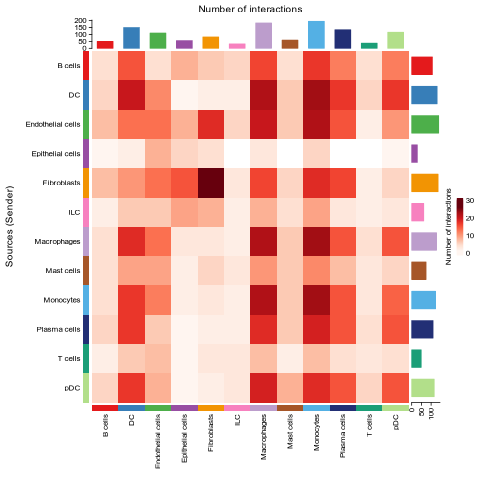

In [11]:
%%R
# 生成细胞通讯网络的热图可视化
p = netVisual_heatmap(
    cellchat,  
    # sources.use = c(2:4), 
    # targets.use = c(2:4), 
    color.heatmap = "Reds")
pdf("./figures/09-cellchat_heatmap.pdf", height = 10, width = 12)
plot(p)
dev.off()
p

Comparing communications on a single object 



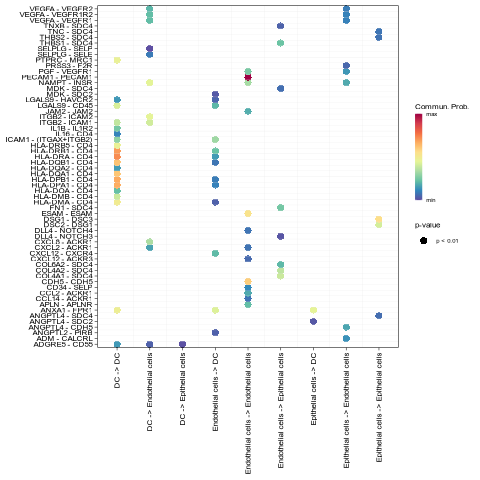

In [12]:
%%R
# 生成细胞通讯网络的气泡图可视化
p = netVisual_bubble(cellchat, 
                 sources.use = c(2:4), 
                 targets.use = c(2:4), 
                 remove.isolate = FALSE)
ggsave("./figures/09-cellchat_buubble.pdf",p, height = 18 / 2.6, width = 24 / 2.6)
p

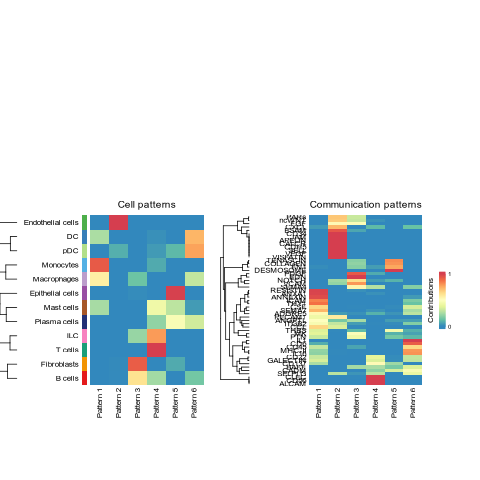

In [18]:
%%R
## 识别特定细胞群的主要信号和一般通信模式
nPatterns = 6
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "incoming", k = nPatterns)

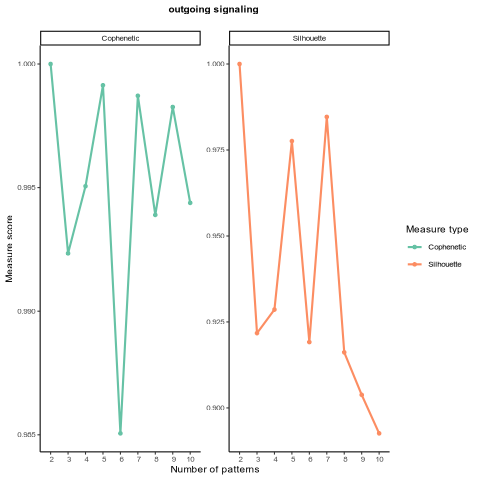

In [19]:
%%R
## Select the number of the patterns for running 'identifyCommunicationPatterns'
## 合适的nPatterns数量是 Cophenetic 和 Silhouette 值开始突然下降的图案数量
selectK(cellchat, pattern="outgoing")

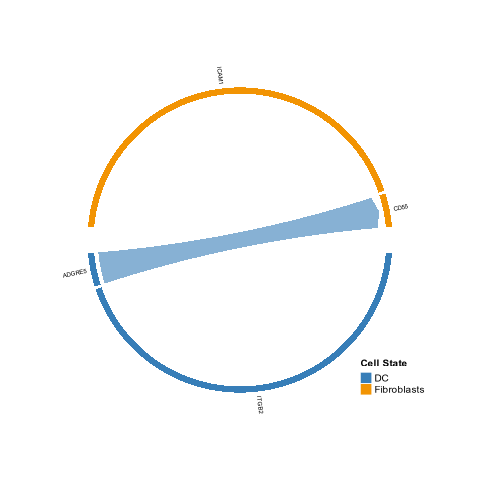

In [20]:
%%R
## 可视化一组配体/受体或信号通路的细胞间通讯的和弦图
netVisual_chord_gene(cellchat,
                     sources.use = c(2),
                     targets.use = c(5),
                     lab.cex = 0.5,legend.pos.y = 30)


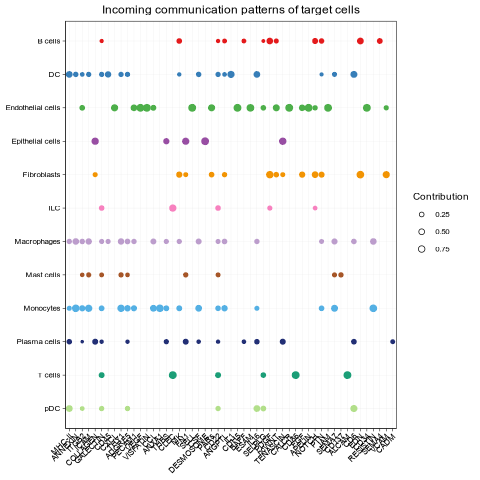

In [21]:
%%R
netAnalysis_dot(cellchat, pattern = "incoming")


Please make sure you have load `library(ggalluvial)` when running this function


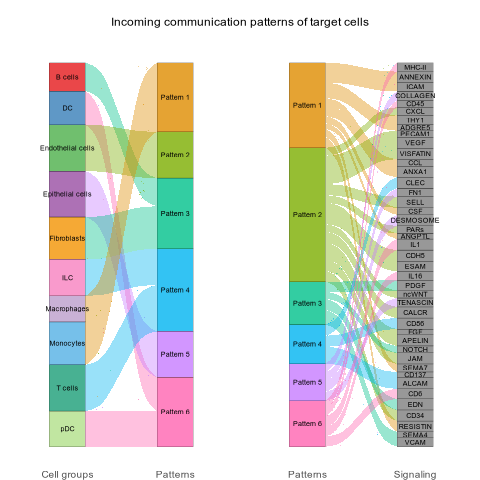

In [22]:
%%R
netAnalysis_river(cellchat, pattern = "incoming")
